# Deep Learning on Lending Club Data

This project uses a deep neural network to predict the likelihood of a loan not being repaid using Lending Club’s public loan dataset. The goal is to identify default risk early using borrower information available at loan issuance. While overall accuracy was comparable to XGBoost, the DNN model showed strong confidence in high-risk predictions, making it a useful tool for risk-averse decision-making.

Key tools: Python, TensorFlow, Scikit-learn, Pandas, Matplotlib


### About the Data Source

We will be sourcing a subset of the LendingClub data, a public dataset available on the Kaggle website: https://www.kaggle.com/datasets/wordsforthewise/lending-club

### Important Note

**Note:** The majority of this notebook shows the preprocessing of the dataset, which was essential due to the raw nature and complexity of the souce data.

If you're primarily interested in the machine learning model implementation, feel free to scroll toward the end of the notebook, or search for the section titled "Model Training".

This structure was intentional: In real-world ML workflows, effective preprocessing is often the most time-consuming and critical part of building a reliable model.

## Step 1: Data Preparation and Preprocessing
Import the necessary libraries:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import os
import zipfile

#'''=== Modeling Imports (To uncomment when ready) ===
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
#'''

**Note:** This dataset is downloaded using the Kaggle API. While running the below cell requires a Kaggle account and API credentials (as outlined [here](https://www.kaggle.com/discussions/getting-started/524433)), the dataset itself is publicly available and was used to demonstrate work with real, historical financial data.

I have already downloaded the dataset locally, so I won't be running the next cell.

The dataset can also be downloaded manually here: https://www.kaggle.com/datasets/wordsforthewise/lending-club

In [ ]:
#Download the dataset (Requires a Kaggle Account and API)
!kaggle datasets download -d wordsforthewise/lending-club

In [ ]:
# Unzip it
with zipfile.ZipFile("lending-club.zip", "r") as zip_ref:
    zip_ref.extractall("lending_club_data")

- Specify the file location:

In [ ]:
df = pd.read_csv('lending_club_data/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv')
#df = pd.read_csv('accepted_2007_to_2018Q4.csv')

In [3]:
#Save a copy of the original dataset
original_df = df.copy()
#Run the following if we need to revert everything: df = original_df.copy()

### Let's explore the dataset to gain a better understanding of its structure and contents. It contains over 2 million samples and 151 features:

In [4]:
df.shape

(2260701, 151)

Display the first 5 samples:

In [5]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


In [7]:
df.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,...,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,0.0,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260664e+06,2.258957e+06,2.260639e+06,2.260668e+06,...,10917.0,10917.000000,10917.0,10917.000000,8651.000000,10917.000000,10917.000000,34246.000000,34246.000000,34246.000000
mean,NaN,1.504693e+04,1.504166e+04,1.502344e+04,1.309283e+01,4.458068e+02,7.799243e+04,1.882420e+01,3.068792e-01,6.985882e+02,...,3.0,155.045981,3.0,13.743886,454.798089,11636.883942,193.994321,5010.664267,47.780365,13.191322
std,NaN,9.190245e+03,9.188413e+03,9.192332e+03,4.832138e+00,2.671735e+02,1.126962e+05,1.418333e+01,8.672303e-01,3.301038e+01,...,0.0,129.040594,0.0,9.671178,375.385500,7625.988281,198.629496,3693.122590,7.311822,8.159980
min,NaN,5.000000e+02,5.000000e+02,0.000000e+00,5.310000e+00,4.930000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,6.100000e+02,...,3.0,0.640000,3.0,0.000000,1.920000,55.730000,0.010000,44.210000,0.200000,0.000000
25%,NaN,8.000000e+03,8.000000e+03,8.000000e+03,9.490000e+00,2.516500e+02,4.600000e+04,1.189000e+01,0.000000e+00,6.750000e+02,...,3.0,59.440000,3.0,5.000000,175.230000,5627.000000,44.440000,2208.000000,45.000000,6.000000
50%,NaN,1.290000e+04,1.287500e+04,1.280000e+04,1.262000e+01,3.779900e+02,6.500000e+04,1.784000e+01,0.000000e+00,6.900000e+02,...,3.0,119.140000,3.0,15.000000,352.770000,10028.390000,133.160000,4146.110000,45.000000,14.000000
75%,NaN,2.000000e+04,2.000000e+04,2.000000e+04,1.599000e+01,5.933200e+02,9.300000e+04,2.449000e+01,0.000000e+00,7.150000e+02,...,3.0,213.260000,3.0,22.000000,620.175000,16151.890000,284.190000,6850.172500,50.000000,18.000000
max,NaN,4.000000e+04,4.000000e+04,4.000000e+04,3.099000e+01,1.719830e+03,1.100000e+08,9.990000e+02,5.800000e+01,8.450000e+02,...,3.0,943.940000,3.0,37.000000,2680.890000,40306.410000,1407.860000,33601.000000,521.350000,181.000000


Display the names of all the features:

In [8]:
df.columns.tolist()

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 '

The target feature is 'loan_status', which will serve as the label for our predictions.
Let's examine all features that contain the word 'status' in their name:

In [9]:
[df[col].value_counts() for col in df.columns if 'status' in col.lower()]

[Source Verified    886231
 Not Verified       744806
 Verified           629631
 Name: verification_status, dtype: int64,
 Fully Paid                                             1076751
 Current                                                 878317
 Charged Off                                             268559
 Late (31-120 days)                                       21467
 In Grace Period                                           8436
 Late (16-30 days)                                         4349
 Does not meet the credit policy. Status:Fully Paid        1988
 Does not meet the credit policy. Status:Charged Off        761
 Default                                                     40
 Name: loan_status, dtype: int64,
 w    1535467
 f     725201
 Name: initial_list_status, dtype: int64,
 Not Verified       57403
 Source Verified    34827
 Verified           23500
 Name: verification_status_joint, dtype: int64,
 COMPLETED    7819
 BROKEN       2266
 ACTIVE        832
 Name: hardshi

## Let’s visualize the distribution of values in the 'loan_status' feature using a bar chart:

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'Fully Paid'),
  Text(1, 0, 'Current'),
  Text(2, 0, 'Charged Off'),
  Text(3, 0, 'In Grace Period'),
  Text(4, 0, 'Late (31-120 days)'),
  Text(5, 0, 'Late (16-30 days)'),
  Text(6, 0, 'Default'),
  Text(7, 0, 'Does not meet the credit policy. Status:Fully Paid'),
  Text(8, 0, 'Does not meet the credit policy. Status:Charged Off')])

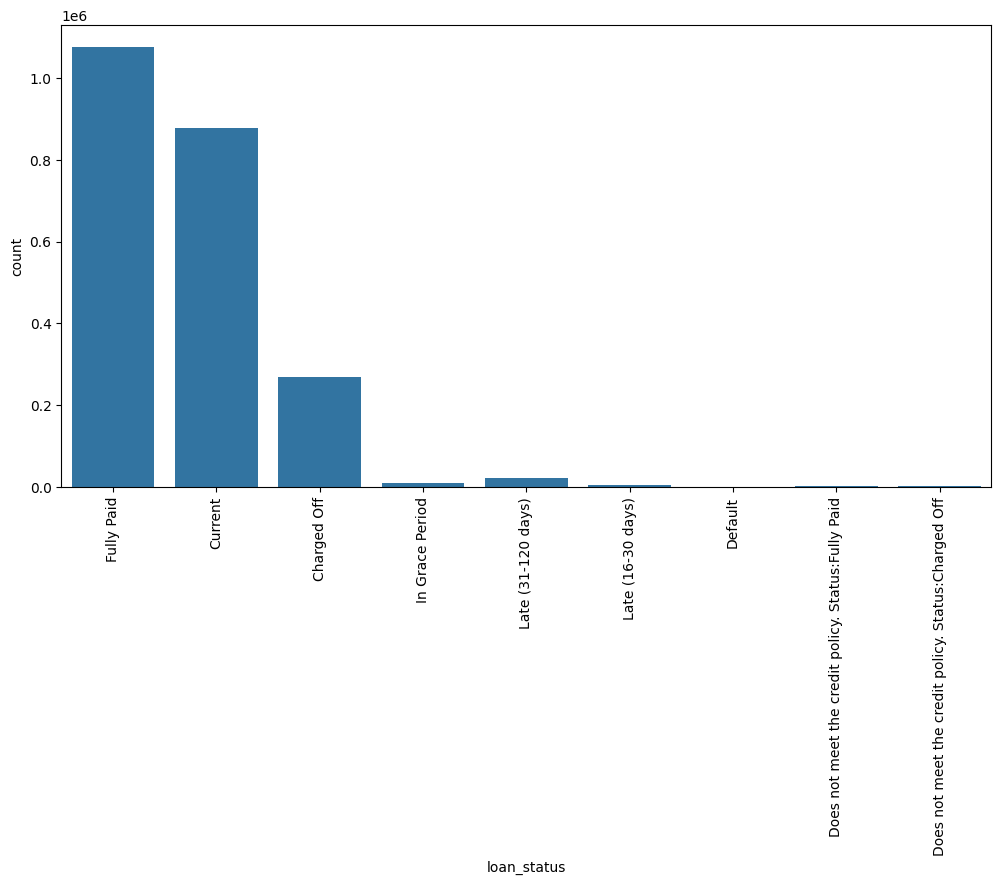

In [10]:
plt.figure(figsize=(12, 6))
sns.countplot(x='loan_status', data=df)
plt.xticks(rotation=90)

- The above label is the one we want to predict with our model. ('loan_status')
- Let's also check the distribution of the loan amounts:

<Figure size 1200x1200 with 0 Axes>

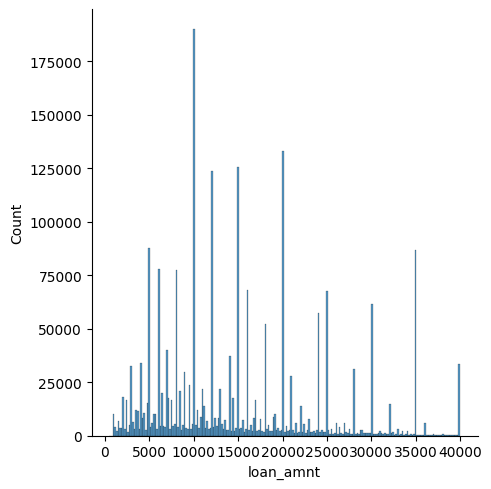

In [11]:
plt.figure(figsize=(12, 12))
sns.displot(df['loan_amnt'])

# We'll take note of how many missing values there are and their percentage:

In [12]:
print(f"total entries: {df.shape[0]}")
print("\nCalculating count of missing value:")
print(df.isnull().sum().sort_values(ascending=False).to_string())
print("\n\nRatio of missing value:")
print(((df.isnull().sum() / len(df)) * 100).sort_values(ascending=False).to_string())

total entries: 2260701

Count of missing value:
member_id                                     2260701
orig_projected_additional_accrued_interest    2252050
hardship_end_date                             2249784
hardship_start_date                           2249784
hardship_type                                 2249784
hardship_reason                               2249784
hardship_status                               2249784
deferral_term                                 2249784
hardship_last_payment_amount                  2249784
hardship_payoff_balance_amount                2249784
hardship_loan_status                          2249784
hardship_dpd                                  2249784
hardship_length                               2249784
payment_plan_start_date                       2249784
hardship_amount                               2249784
settlement_term                               2226455
debt_settlement_flag_date                     2226455
settlement_status                 

member_id                                     100.000000
orig_projected_additional_accrued_interest     99.617331
hardship_end_date                              99.517097
hardship_start_date                            99.517097
hardship_type                                  99.517097
hardship_reason                                99.517097
hardship_status                                99.517097
deferral_term                                  99.517097
hardship_last_payment_amount                   99.517097
hardship_payoff_balance_amount                 99.517097
hardship_loan_status                           99.517097
hardship_dpd                                   99.517097
hardship_length                                99.517097
payment_plan_start_date                        99.517097
hardship_amount                                99.517097
settlement_term                                98.485160
debt_settlement_flag_date                      98.485160
settlement_status              

### We can see that 'member_id' is always empty. We can drop this feature.

### We'll also identify and drop any features with more than 90% missing values. While thresholds like 95% or higher are common, we're using 90% in this case to streamline the dataset and focus on model development.

In [13]:
null_ratios = df.isnull().sum() / len(df)
high_nulls = null_ratios[null_ratios > 0.90].sort_values(ascending=False)
print(high_nulls)

member_id                                     1.000000
orig_projected_additional_accrued_interest    0.996173
hardship_type                                 0.995171
hardship_last_payment_amount                  0.995171
hardship_payoff_balance_amount                0.995171
hardship_loan_status                          0.995171
hardship_dpd                                  0.995171
hardship_length                               0.995171
payment_plan_start_date                       0.995171
hardship_end_date                             0.995171
hardship_start_date                           0.995171
hardship_amount                               0.995171
deferral_term                                 0.995171
hardship_status                               0.995171
hardship_reason                               0.995171
settlement_term                               0.984852
settlement_percentage                         0.984852
settlement_amount                             0.984852
settlement

In [14]:
df = df.drop(columns=high_nulls.index)
df.shape

(2260701, 113)


## We will also drop features that are clearly unavailable at time of loan application.

For example:

- Post-loan financial features (e.g., total_pymnt, recoveries, out_prncp).

- Derived credit behavior post-loan (e.g., num_tl_30dpd)

On the other hand, features like mths_since_last_delinq are typically available in a borrower's credit report at the time of application and will be retained.
Similarly, delinq_2yrs is preserved, as it reflects historical credit behavior leading up to the loan and does not pose a risk of data leakage—it would have been known during the underwriting process.

In [15]:
leakage_features = [
    'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'total_pymnt', 'total_pymnt_inv', 
    'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
    'out_prncp', 'out_prncp_inv', 'recoveries', 'collection_recovery_fee',
    'policy_code','mths_since_last_major_derog','mths_since_recent_revol_delinq','mths_since_rcnt_il',
    'mo_sin_rcnt_rev_tl_op','debt_settlement_flag','last_pymnt_d','next_pymnt_d','last_credit_pull_d',
    'open_rv_12m', 'open_rv_24m',
    'hardship_flag','funded_amnt_inv','disbursement_method',
    'chargeoff_within_12_mths','acc_now_delinq','num_tl_90g_dpd_24m','num_tl_120dpd_2m','num_tl_30dpd','delinq_amnt','num_accts_ever_120_pd','mths_since_last_record'
]

df = df.drop(columns=leakage_features)
df.shape

(2260701, 79)

In [16]:
df.select_dtypes(exclude=['number']).head().transpose()

,0,1,2,3,4
id,68407277,68355089,68341763,66310712,68476807
term,36 months,36 months,60 months,60 months,60 months
grade,C,C,B,C,F
sub_grade,C4,C1,B4,C5,F1
emp_title,leadman,Engineer,truck driver,Information Systems Officer,Contract Specialist
emp_length,10+ years,10+ years,10+ years,10+ years,3 years
home_ownership,MORTGAGE,MORTGAGE,MORTGAGE,MORTGAGE,MORTGAGE
verification_status,Not Verified,Not Verified,Not Verified,Source Verified,Source Verified
issue_d,Dec-2015,Dec-2015,Dec-2015,Dec-2015,Dec-2015
loan_status,Fully Paid,Fully Paid,Fully Paid,Current,Fully Paid


In [17]:
df['grade'].unique()

array(['C', 'B', 'F', 'A', 'E', 'D', 'G', nan], dtype=object)

In [18]:
df['sub_grade'].unique()

array(['C4', 'C1', 'B4', 'C5', 'F1', 'C3', 'B2', 'B1', 'A2', 'B5', 'C2',
       'E2', 'A4', 'E3', 'A1', 'D4', 'F3', 'D1', 'B3', 'E4', 'D3', 'D2',
       'D5', 'A5', 'F2', 'E1', 'F5', 'E5', 'A3', 'G2', 'G1', 'G3', 'G4',
       'F4', 'G5', nan], dtype=object)

In [19]:
df['purpose'].unique()

array(['debt_consolidation', 'small_business', 'home_improvement',
       'major_purchase', 'credit_card', 'other', 'house', 'vacation',
       'car', 'medical', 'moving', 'renewable_energy', 'wedding',
       'educational', nan], dtype=object)

In [20]:
df['title'].unique()

array(['Debt consolidation', 'Business', nan, ..., 'takeitaway',
       'Creditt Card Loan', 'debt reduction/hone updates'], dtype=object)

In [21]:
#If we print the number of unique values for the string features, we can have a glance at which features have high cardinality:
df.select_dtypes(include=['object', 'category']).nunique()

id                     2260701
term                         2
grade                        7
sub_grade                   35
emp_title               512694
emp_length                  11
home_ownership               6
verification_status          3
issue_d                    139
loan_status                  9
pymnt_plan                   2
url                    2260668
purpose                     14
title                    63155
zip_code                   956
addr_state                  51
earliest_cr_line           754
initial_list_status          2
application_type             2
dtype: int64

We will drop the following columns for the below reasons.

'id': it is unique for each row and will not be useful.

url: Drop. Purely administrative, not useful.

(Redundant columns) 'title' is user-generated and messy; 'purpose' is standardized and easier to model.
'grade' can be dropped because the sub_grade already shows the grade.

emp_title: High cardinality + messy text = hard to use directly.

zip_code:
While it might be possible to extract the first 3 digits or map to external income data, adds unnecessary complexity.

pymnt_plan: As it's almost always one value, drop.

In [22]:
df = df.drop(columns=['id', 'title','grade','url','emp_title','zip_code','pymnt_plan'])
df.shape

(2260701, 72)

In [23]:
df['emp_length'].value_counts(dropna=False)

10+ years    748005
2 years      203677
< 1 year     189988
3 years      180753
1 year       148403
NaN          146940
5 years      139698
4 years      136605
6 years      102628
7 years       92695
8 years       91914
9 years       79395
Name: emp_length, dtype: int64

# Let's verify the relationship between employment length and 'Charged Off' rate.

In [24]:
emp_co = df[df['loan_status']=='Charged Off'].groupby("emp_length").count()['loan_status']

In [25]:
emp_fp = df[df['loan_status']=='Fully Paid'].groupby("emp_length").count()['loan_status']

In [26]:
emp_co/(emp_co+emp_fp)

emp_length
1 year       0.205641
10+ years    0.187827
2 years      0.198073
3 years      0.199690
4 years      0.197378
5 years      0.196010
6 years      0.193519
7 years      0.194888
8 years      0.199338
9 years      0.199011
< 1 year     0.205273
Name: loan_status, dtype: float64

In [27]:
emp_map = {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
}
df['emp_length'] = df['emp_length'].map(emp_map)

In [28]:
median_emp = df['emp_length'].median()
df['emp_length'] = df['emp_length'].fillna(median_emp)
df['emp_length'].value_counts(dropna=False)

10.0    748005
6.0     249568
2.0     203677
0.0     189988
3.0     180753
1.0     148403
5.0     139698
4.0     136605
7.0      92695
8.0      91914
9.0      79395
Name: emp_length, dtype: int64

In [29]:
df['term'].value_counts(dropna=False)

 36 months    1609754
 60 months     650914
NaN                33
Name: term, dtype: int64

In [30]:
# Replace the 33 NaNs with the most common value.
df['term'] = df['term'].fillna(df['term'].mode()[0])
df['term'].value_counts(dropna=False)

 36 months    1609787
 60 months     650914
Name: term, dtype: int64

In [31]:
df['term'] = df['term'].str.extract('(\d+)')  # Extract digits only
df['term'] = pd.to_numeric(df['term'])
df['term']

0          36
1          36
2          60
3          60
4          60
           ..
2260696    60
2260697    60
2260698    60
2260699    36
2260700    36
Name: term, Length: 2260701, dtype: int64

In [32]:
df['sub_grade'].value_counts(dropna=False)

C1     145903
B5     140288
B4     139793
B3     131514
C2     131116
C3     129193
C4     127115
B2     126621
B1     125341
C5     116726
A5     107617
A4      95874
A1      86790
D1      81787
A3      73184
D2      72899
A2      69562
D3      64819
D4      56896
D5      48023
E1      33573
E2      29924
E3      26708
E4      22763
E5      22671
F1      13413
F2       9305
F3       7791
F4       6124
F5       5167
G1       4106
G2       2688
G3       2094
G4       1712
G5       1568
NaN        33
Name: sub_grade, dtype: int64

In [33]:
df = df.dropna(subset=['sub_grade'])

In [34]:
df['loan_status'].value_counts(dropna=False)

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

We will simplify these categories into Good customers and Bad customers. For example, Late (16-30 days) is already in default territory. So we will make a conservative classification as Bad (Charged Off). The status 'Current' takes up a notable percentage of the dataset, however it does not provide useful information, as we don't know if they were able to pay. Hence we will drop these.

In [35]:
def map_loan_status(status):
    if status in ["Fully Paid", "Does not meet the credit policy. Status:Fully Paid"]:
        return "Fully Paid"
    elif status in ["Charged Off", "Late (31-120 days)", "Late (16-30 days)", 
                    "Default", "Does not meet the credit policy. Status:Charged Off"]:
        return "Charged Off"
    else:
        return None  # for 'Current', 'In Grace Period'

In [36]:
df["loan_status"] = df["loan_status"].apply(map_loan_status)

In [37]:
# Drop rows where loan_repaid is None
df = df[df["loan_status"].notnull()]

([0, 1], [Text(0, 0, 'Fully Paid'), Text(1, 0, 'Charged Off')])

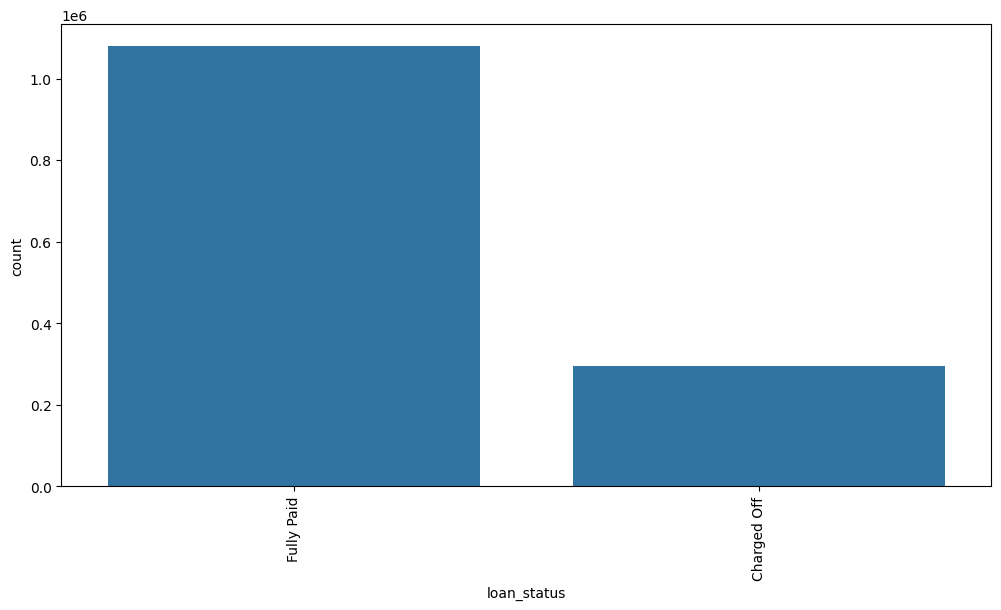

In [38]:
plt.figure(figsize=(12, 6))
sns.countplot(x='loan_status', data=df)
plt.xticks(rotation=90)

We see above that 'Fully Paid' far exceeds 'Charged Off', indicating an uneven dataset.

Let's also verify if the grades are related to a customer's default rate:

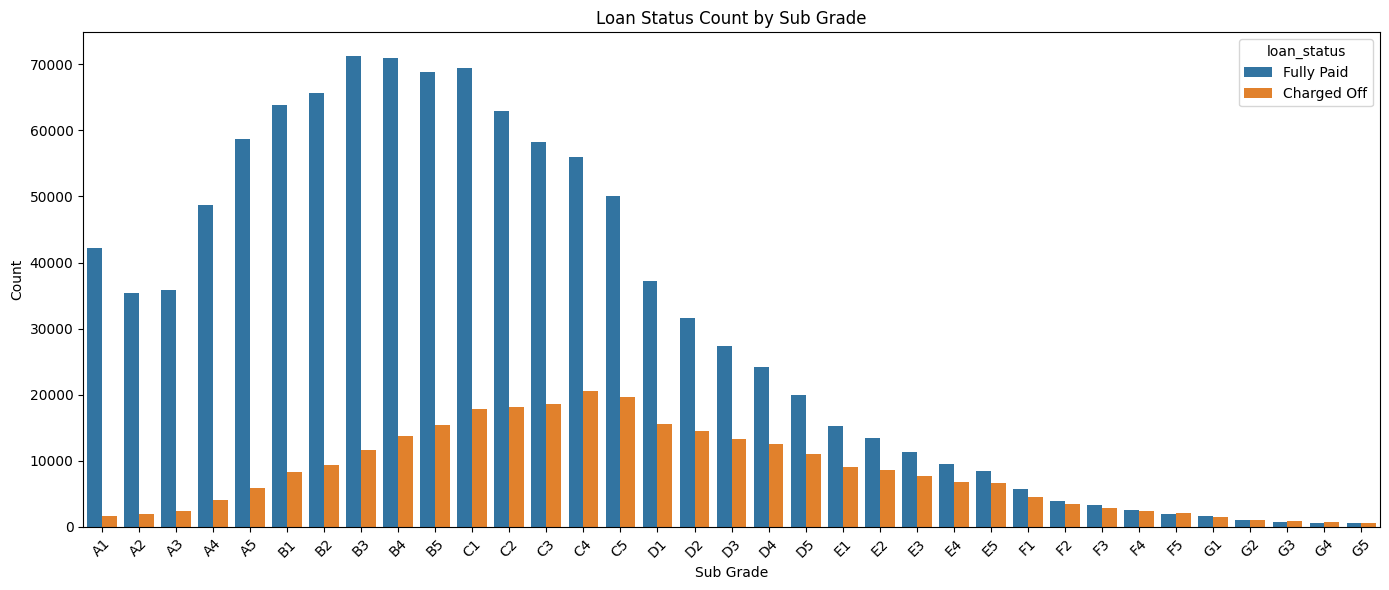

In [39]:
plt.figure(figsize=(14, 6))
sns.countplot(data=df, x='sub_grade', hue='loan_status', order=sorted(df['sub_grade'].unique()))

plt.title('Loan Status Count by Sub Grade')
plt.xlabel('Sub Grade')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [40]:
df['loan_repaid'] = df['loan_status'].map({'Fully Paid':1, 'Charged Off':0})
df[['loan_repaid', 'loan_status']]

,loan_repaid,loan_status
0,1,Fully Paid
1,1,Fully Paid
2,1,Fully Paid
4,1,Fully Paid
5,1,Fully Paid
...,...,...
2260688,1,Fully Paid
2260690,1,Fully Paid
2260691,0,Charged Off
2260692,1,Fully Paid


In [41]:
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y', errors='coerce')
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y', errors='coerce')  # when loan was issued

# Compute credit history length in years
df['credit_history_years'] = (df['issue_d'] - df['earliest_cr_line']).dt.days / 365

df.drop(['earliest_cr_line', 'issue_d'], axis=1, inplace=True)

In [42]:
correlations = df.select_dtypes(include=['number']).corr()['loan_repaid'].sort_values(ascending=False)

# Convert to DataFrame for printing output
correlations_df = correlations.reset_index()
correlations_df.columns = ['Feature', 'Correlation with loan_repaid']
print(correlations_df.to_string(index=False))

                   Feature  Correlation with loan_repaid
               loan_repaid                      1.000000
            fico_range_low                      0.129188
           fico_range_high                      0.129186
                  mort_acc                      0.080139
            bc_open_to_buy                      0.078908
               avg_cur_bal                      0.078310
           tot_hi_cred_lim                      0.077608
               tot_cur_bal                      0.070672
            total_bc_limit                      0.070661
     mths_since_recent_inq                      0.055929
            mo_sin_rcnt_tl                      0.053520
      mo_sin_old_rev_tl_op                      0.052391
          total_rev_hi_lim                      0.052181
      mths_since_recent_bc                      0.051134
                annual_inc                      0.039071
                max_bal_bc                      0.038770
      credit_history_years     

1. To streamline the model and reduce noise, I evaluated the correlation of each numerical feature with the target variable loan_repaid. 

- A few in the 0.07 – 0.09 range that seem potentially useful (mort_acc, avg_cur_bal, etc.)
- A long tail of features between 0.01 – 0.06, which is borderline 

2. Of these features, 'emp_length' and 'total_acc' or total accounts may be useful. We will keep these for now.

In [43]:
# Drop features with very weak absolute correlation (< 0.03)
target_corr = df.corr(numeric_only=True)['loan_repaid'].drop(['loan_repaid','total_acc','emp_length'])

# Identify low-correlation features
low_corr_features = target_corr[abs(target_corr) < 0.03].index.tolist()

# Drop them
df = df.drop(columns=low_corr_features)

print(f"Dropped {len(low_corr_features)} features with abs(corr) < 0.03")
print(f"{low_corr_features}")
df.shape

Dropped 22 features with abs(corr) < 0.03
['delinq_2yrs', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal', 'collections_12_mths_ex_med', 'tot_coll_amt', 'open_act_il', 'total_bal_il', 'total_cu_tl', 'mo_sin_old_il_acct', 'mths_since_recent_bc_dlq', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_rev_accts', 'num_sats', 'pct_tl_nvr_dlq', 'pub_rec_bankruptcies', 'tax_liens', 'total_bal_ex_mort', 'total_il_high_credit_limit']


(1373915, 50)

In [44]:
print(f"total entries: {df.shape[0]}")

print("\n\nRatio of missing value:")
print(((df.isnull().sum() / len(df)) * 100).sort_values(ascending=False).to_string())

total entries: 1373915


Ratio of missing value:
il_util                  64.672196
all_util                 59.133716
inq_last_12m             59.129568
open_acc_6m              59.129568
max_bal_bc               59.129495
open_il_24m              59.129495
open_il_12m              59.129495
inq_fi                   59.129495
mths_since_recent_inq    13.026352
avg_cur_bal               5.116692
mo_sin_old_rev_tl_op      5.115091
num_actv_bc_tl            5.115018
total_rev_hi_lim          5.115018
tot_hi_cred_lim           5.115018
num_tl_op_past_12m        5.115018
num_rev_tl_bal_gt_0       5.115018
tot_cur_bal               5.115018
num_actv_rev_tl           5.115018
num_op_rev_tl             5.115018
mo_sin_rcnt_tl            5.115018
bc_util                   4.734063
percent_bc_gt_75          4.707133
bc_open_to_buy            4.677000
mths_since_recent_bc      4.608218
acc_open_past_24mths      3.641419
mort_acc                  3.641419
total_bc_limit            3.641419
revol_

In [45]:
# List of features with <0.1% missing values
low_missing_features = [
    'revol_util',
    'dti',
    'inq_last_6mths',
    'total_acc',
    'credit_history_years',
    'annual_inc'
]

# Drop rows where any of these features are missing
df = df.dropna(subset=low_missing_features)

In [46]:
# Compute correlation matrix for numerical features
corr_matrix = df.select_dtypes(include=['number']).corr().abs()

# Mask the upper triangle and diagonal to avoid duplicate and self-pairs
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
masked_corr = corr_matrix.mask(mask)

# Unstack and sort correlation values
sorted_pairs = masked_corr.unstack().dropna().sort_values(ascending=False)

# Show top 40 highly correlated feature pairs
print(sorted_pairs.head(40).to_string())

fico_range_low        fico_range_high          1.000000
loan_amnt             funded_amnt              0.999556
num_actv_rev_tl       num_rev_tl_bal_gt_0      0.981947
tot_cur_bal           tot_hi_cred_lim          0.972983
funded_amnt           installment              0.953664
loan_amnt             installment              0.953011
mo_sin_old_rev_tl_op  credit_history_years     0.917443
revol_util            bc_util                  0.855340
bc_util               percent_bc_gt_75         0.844759
tot_cur_bal           avg_cur_bal              0.838802
bc_open_to_buy        total_bc_limit           0.838265
num_actv_bc_tl        num_actv_rev_tl          0.807768
                      num_rev_tl_bal_gt_0      0.800731
avg_cur_bal           tot_hi_cred_lim          0.798118
num_op_rev_tl         num_rev_tl_bal_gt_0      0.795270
num_actv_rev_tl       num_op_rev_tl            0.790929
acc_open_past_24mths  num_tl_op_past_12m       0.758153
open_il_12m           open_il_24m              0

In [47]:
# The features fico_range_low VS fico_range_high have a 100% correlation.
# To address multicollinearity and simplify the model, I dropped features with a correlation coefficient above 0.95. (Near-identical input.)
# However, we should probably keep loan_amnt and 'installment' since we are dropping 'funded_amt'.
df.drop(['fico_range_high','funded_amnt','mo_sin_old_rev_tl_op'], axis=1, inplace=True)

## 'total_acc' and 'mort_acc' has a roughly 37% correlation. Since 'mort_acc' has too many missing values to ignore, we will fill the null values by looking up their total_acc number and taking the average of those.

In [48]:
total_acc_avg = df.groupby('total_acc').mean(numeric_only=True)['mort_acc']
total_acc_avg

total_acc
1.0           NaN
2.0      0.000000
3.0      0.035205
4.0      0.072554
5.0      0.114693
           ...   
156.0    1.000000
162.0    6.000000
169.0    2.000000
173.0    2.000000
176.0    2.000000
Name: mort_acc, Length: 144, dtype: float64

In [49]:
def fill_mort_acc(total_acc,mort_acc):
    if np.isnan(mort_acc):
        return total_acc_avg[total_acc]
    else:
        return mort_acc

In [50]:
df['mort_acc'] = df.apply(lambda x: fill_mort_acc(x['total_acc'],x['mort_acc']), axis=1)

print(f"total entries: {df.shape[0]}")
print("\nCount of missing value:")
print(df.isnull().sum().sort_values(ascending=False).to_string())

total entries: 1372585

Count of missing value:
il_util                  887871
inq_fi                   811914
all_util                 811914
max_bal_bc               811914
inq_last_12m             811914
open_il_24m              811914
open_il_12m              811914
open_acc_6m              811914
mths_since_recent_inq    178621
tot_cur_bal               70155
avg_cur_bal               70155
mo_sin_rcnt_tl            70155
total_rev_hi_lim          70155
num_actv_bc_tl            70155
num_actv_rev_tl           70155
num_op_rev_tl             70155
num_rev_tl_bal_gt_0       70155
num_tl_op_past_12m        70155
tot_hi_cred_lim           70155
bc_util                   64106
percent_bc_gt_75          63856
bc_open_to_buy            63442
mths_since_recent_bc      62560
acc_open_past_24mths      49928
total_bc_limit            49928
mort_acc                     20
loan_repaid                   0
loan_amnt                     0
term                          0
loan_status             

In [51]:
df[df['mort_acc'].isnull()]

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,...,num_actv_bc_tl,num_actv_rev_tl,num_op_rev_tl,num_rev_tl_bal_gt_0,num_tl_op_past_12m,percent_bc_gt_75,tot_hi_cred_lim,total_bc_limit,loan_repaid,credit_history_years
1653425,5850.0,36,7.68,182.46,A2,0.0,RENT,28800.0,Verified,Fully Paid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,7.172603
1653489,1000.0,36,12.29,33.36,C5,0.0,RENT,17000.0,Not Verified,Fully Paid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.498630
1653808,2000.0,36,10.08,64.61,B3,10.0,RENT,19200.0,Not Verified,Fully Paid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.838356
1653914,2600.0,36,10.71,84.77,B5,6.0,RENT,18720.0,Not Verified,Fully Paid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.671233
1653934,5000.0,36,11.41,164.67,C3,0.0,RENT,30500.0,Not Verified,Fully Paid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.504110
1653946,550.0,36,12.04,18.28,C5,1.0,RENT,18720.0,Not Verified,Fully Paid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3.000000
1653964,2000.0,36,12.04,66.47,C5,1.0,RENT,18720.0,Not Verified,Fully Paid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3.084932
1653984,2500.0,36,13.30,84.60,D4,1.0,RENT,24960.0,Not Verified,Charged Off,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.504110
1653992,3000.0,36,11.41,98.80,C3,3.0,RENT,13000.0,Not Verified,Fully Paid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.671233
1654045,7500.0,36,11.22,246.33,C4,4.0,OWN,31920.0,Not Verified,Fully Paid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.334247


In [52]:
df = df.dropna(subset='mort_acc')

Rather than spending excessive time on imputing partially missing columns that only marginally improve model performance, I prioritized an efficient cleanup approach by removing rows with missing values in features that were mostly complete (≥ 90%). This allowed me to retain ~90% of the data while eliminating over 15 columns that would otherwise require complex imputation — Let's focus on the core deep learning architecture and insights.

In [53]:
#Missingness impact check:

features_with_missing = [
    'il_util', 'all_util', 'max_bal_bc', 'inq_last_12m', 'open_il_24m',
    'open_il_12m', 'open_acc_6m', 'inq_fi', 'mths_since_recent_inq',
    'tot_cur_bal', 'avg_cur_bal', 'mo_sin_rcnt_tl', 'total_rev_hi_lim', 'tot_hi_cred_lim', 'num_actv_rev_tl',
    'num_op_rev_tl', 'num_rev_tl_bal_gt_0', 'num_actv_bc_tl',
    'num_tl_op_past_12m', 'bc_util', 'percent_bc_gt_75', 'bc_open_to_buy',
    'mths_since_recent_bc', 'total_bc_limit', 'acc_open_past_24mths'
]

print(f"Overall charged off rate: {(df['loan_repaid'] == 0).mean()}")
for feature in features_with_missing:
    null_mask = df[feature].isnull()
    total_null = null_mask.sum()
    if total_null == 0:
        continue
    chargeoff_rate = (df.loc[null_mask, 'loan_repaid'] == 0).mean()
    print(f"{feature:<25} Missing: {total_null:>7} | Charge-off rate: {chargeoff_rate:.2%}")

Overall charged off rate: 0.21482115601082644
il_util                   Missing:  887851 | Charge-off rate: 19.12%
all_util                  Missing:  811894 | Charge-off rate: 18.60%
max_bal_bc                Missing:  811894 | Charge-off rate: 18.60%
inq_last_12m              Missing:  811894 | Charge-off rate: 18.60%
open_il_24m               Missing:  811894 | Charge-off rate: 18.60%
open_il_12m               Missing:  811894 | Charge-off rate: 18.60%
open_acc_6m               Missing:  811894 | Charge-off rate: 18.60%
inq_fi                    Missing:  811894 | Charge-off rate: 18.60%
mths_since_recent_inq     Missing:  178601 | Charge-off rate: 16.09%
tot_cur_bal               Missing:   70135 | Charge-off rate: 15.75%
avg_cur_bal               Missing:   70135 | Charge-off rate: 15.75%
mo_sin_rcnt_tl            Missing:   70135 | Charge-off rate: 15.75%
total_rev_hi_lim          Missing:   70135 | Charge-off rate: 15.75%
tot_hi_cred_lim           Missing:   70135 | Charge-off r

In [54]:
print(f"total entries before dropping missing values: {df.shape[0]}")

columns_to_drop_missing_rows = [
    'tot_cur_bal', 'avg_cur_bal', 'mo_sin_rcnt_tl',
    'total_rev_hi_lim', 'tot_hi_cred_lim', 'num_actv_rev_tl', 'num_op_rev_tl', 'num_rev_tl_bal_gt_0', 'num_actv_bc_tl', 'num_tl_op_past_12m','bc_util','percent_bc_gt_75','bc_open_to_buy','mths_since_recent_bc','total_bc_limit','acc_open_past_24mths'
]

df = df.dropna(subset=columns_to_drop_missing_rows)
print(f"Remaining rows: {df.shape[0]}")

total entries before dropping missing values: 1372565
Remaining rows: 1288101


In [55]:
print(f"total entries: {df.shape[0]}")

print("\n\nRatio of missing value:")
print(((df.isnull().sum() / len(df)) * 100).sort_values(ascending=False).to_string())

total entries: 1288101


Ratio of missing value:
il_util                  62.835756
inq_last_12m             57.002052
max_bal_bc               57.002052
inq_fi                   57.002052
open_il_24m              57.002052
open_il_12m              57.002052
open_acc_6m              57.002052
all_util                 57.002052
mths_since_recent_inq     9.644973
num_op_rev_tl             0.000000
acc_open_past_24mths      0.000000
loan_repaid               0.000000
total_bc_limit            0.000000
tot_hi_cred_lim           0.000000
percent_bc_gt_75          0.000000
num_tl_op_past_12m        0.000000
num_rev_tl_bal_gt_0       0.000000
avg_cur_bal               0.000000
num_actv_rev_tl           0.000000
bc_open_to_buy            0.000000
bc_util                   0.000000
mo_sin_rcnt_tl            0.000000
total_rev_hi_lim          0.000000
mths_since_recent_bc      0.000000
num_actv_bc_tl            0.000000
mort_acc                  0.000000
loan_amnt                 0.000000
term  

In [56]:
cols_to_check = [
    'il_util', 'inq_last_12m', 'max_bal_bc', 'inq_fi',
    'open_il_24m', 'open_il_12m', 'open_acc_6m', 'all_util',
    'mths_since_recent_inq'
]

for col in cols_to_check:
    corr = df[[col, 'loan_repaid']].dropna().corr().iloc[0, 1]
    print(f"Correlation between {col} and loan_repaid: {corr:.4f}")

Correlation between il_util and loan_repaid: -0.0412
Correlation between inq_last_12m and loan_repaid: -0.0569
Correlation between max_bal_bc and loan_repaid: 0.0391
Correlation between inq_fi and loan_repaid: -0.0406
Correlation between open_il_24m and loan_repaid: -0.0325
Correlation between open_il_12m and loan_repaid: -0.0352
Correlation between open_acc_6m and loan_repaid: -0.0548
Correlation between all_util and loan_repaid: -0.0844
Correlation between mths_since_recent_inq and loan_repaid: 0.0561


- These features, which are missing more than 50% of the time have a correlation below 0.1
- We could fill all the missing values with median values to experiment, however this time we will drop them.

In [57]:
df.drop(columns=cols_to_check, inplace=True)
df.shape

(1288101, 38)

In [58]:
print(f"total entries: {df.shape[0]}")

print("\n\nRatio of missing value:")
print(((df.isnull().sum() / len(df)) * 100).sort_values(ascending=False).to_string())

total entries: 1288101


Ratio of missing value:
loan_amnt               0.0
num_actv_bc_tl          0.0
acc_open_past_24mths    0.0
avg_cur_bal             0.0
bc_open_to_buy          0.0
bc_util                 0.0
mo_sin_rcnt_tl          0.0
mort_acc                0.0
mths_since_recent_bc    0.0
num_actv_rev_tl         0.0
term                    0.0
num_op_rev_tl           0.0
num_rev_tl_bal_gt_0     0.0
num_tl_op_past_12m      0.0
percent_bc_gt_75        0.0
tot_hi_cred_lim         0.0
total_bc_limit          0.0
loan_repaid             0.0
total_rev_hi_lim        0.0
tot_cur_bal             0.0
application_type        0.0
initial_list_status     0.0
int_rate                0.0
installment             0.0
sub_grade               0.0
emp_length              0.0
home_ownership          0.0
annual_inc              0.0
verification_status     0.0
loan_status             0.0
purpose                 0.0
addr_state              0.0
dti                     0.0
fico_range_low          0.0

In [59]:
df.select_dtypes(include=['object', 'category']).nunique()

sub_grade              35
home_ownership          6
verification_status     3
loan_status             2
purpose                14
addr_state             51
initial_list_status     2
application_type        2
dtype: int64

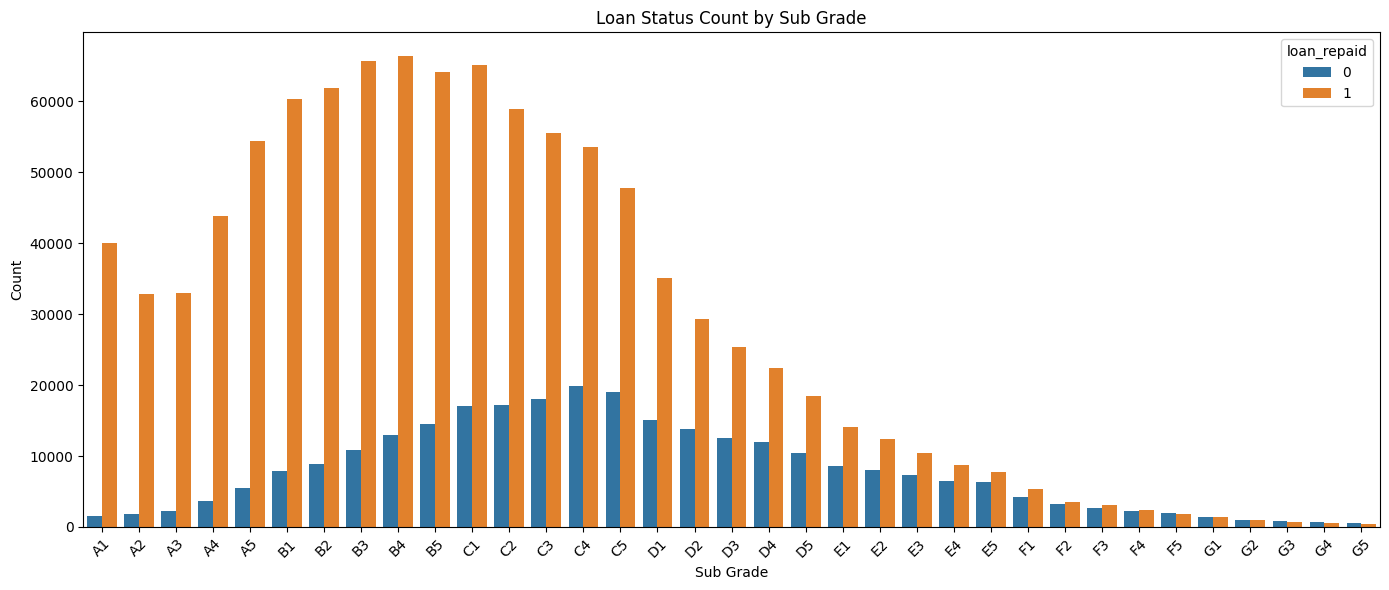

In [60]:
plt.figure(figsize=(14, 6))
sns.countplot(data=df, x='sub_grade', hue='loan_repaid', order=sorted(df['sub_grade'].unique()))

plt.title('Loan Status Count by Sub Grade')
plt.xlabel('Sub Grade')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [61]:
df['sub_grade'].unique()

array(['C4', 'C1', 'B4', 'F1', 'C3', 'B2', 'B1', 'A2', 'B5', 'C2', 'E2',
       'A4', 'E3', 'C5', 'A1', 'D4', 'F3', 'D1', 'B3', 'D3', 'D5', 'A5',
       'F2', 'E4', 'D2', 'E1', 'F5', 'E5', 'A3', 'G2', 'G1', 'G3', 'G4',
       'F4', 'G5'], dtype=object)

In [62]:
sub_grade_order = [
    'A1', 'A2', 'A3', 'A4', 'A5',
    'B1', 'B2', 'B3', 'B4', 'B5',
    'C1', 'C2', 'C3', 'C4', 'C5',
    'D1', 'D2', 'D3', 'D4', 'D5',
    'E1', 'E2', 'E3', 'E4', 'E5',
    'F1', 'F2', 'F3', 'F4', 'F5',
    'G1', 'G2', 'G3', 'G4', 'G5'
]

# Create a mapping from sub_grade to an ordinal integer
sub_grade_map = {grade: idx for idx, grade in enumerate(sub_grade_order)}

# Apply the mapping
df['sub_grade'] = df['sub_grade'].map(sub_grade_map)
df['sub_grade']

0          13
1          10
2           8
4          25
5          12
           ..
2260688     6
2260690    12
2260691    13
2260692    10
2260697    13
Name: sub_grade, Length: 1288101, dtype: int64

# Since 'addr_state' has 51 unique values, one-hot encoding may not be ideal. First, let's check the average 'loan_repaid' rate per state:

In [63]:
df.groupby('addr_state')['loan_repaid'].mean()

addr_state
AK    0.786918
AL    0.744022
AR    0.737060
AZ    0.787296
CA    0.786650
CO    0.832093
CT    0.806847
DC    0.849021
DE    0.786130
FL    0.764894
GA    0.799214
HI    0.781410
IA    1.000000
ID    0.786471
IL    0.802489
IN    0.770949
KS    0.817647
KY    0.773277
LA    0.747665
MA    0.790272
MD    0.764041
ME    0.843781
MI    0.780719
MN    0.786170
MO    0.768959
MS    0.711677
MT    0.818157
NC    0.774601
ND    0.770312
NE    0.727523
NH    0.837299
NJ    0.770252
NM    0.770517
NV    0.766495
NY    0.757075
OH    0.779437
OK    0.745333
OR    0.844926
PA    0.772272
RI    0.805021
SC    0.820659
SD    0.770566
TN    0.771956
TX    0.782458
UT    0.815305
VA    0.780693
VT    0.846396
WA    0.830313
WI    0.796393
WV    0.834240
WY    0.814481
Name: loan_repaid, dtype: float64

# The rate per state floats around the same range, but IA sticks out, which suggests that IA likely has limited samples.

In [64]:
df.groupby('addr_state')['loan_repaid'].count().sort_values()

addr_state
IA         1
ND      1637
ID      1700
ME      2042
VT      2539
SD      2650
WY      2776
AK      3027
DC      3166
DE      3605
NE      3626
MT      3657
WV      4597
RI      5616
NH      6220
HI      6455
MS      6680
NM      7055
UT      9448
AR      9660
KS     10699
OK     11839
KY     12319
LA     14774
SC     15228
OR     15657
AL     15892
WI     17077
CT     18752
NV     19567
MO     20347
TN     20461
IN     21851
MN     23051
WA     27645
CO     28480
MA     29276
MD     29895
AZ     31424
MI     34002
VA     35863
NC     36371
GA     41462
OH     41988
PA     43407
NJ     46120
IL     49577
FL     91831
NY    104810
TX    106200
CA    186079
Name: loan_repaid, dtype: int64

In [65]:
df.drop(columns='addr_state', inplace=True)

# We will check why Home Ownership has 6 categories:
df['home_ownership'].value_counts()

MORTGAGE    638850
RENT        507898
OWN         140968
ANY            297
NONE            44
OTHER           44
Name: home_ownership, dtype: int64

In [66]:
rare_categories = ['ANY', 'OTHER', 'NONE']

# Replace them with 'OTHER'
df['home_ownership'] = df['home_ownership'].replace(rare_categories, 'OTHER')
df['home_ownership'].value_counts()

MORTGAGE    638850
RENT        507898
OWN         140968
OTHER          385
Name: home_ownership, dtype: int64

In [67]:
df = df.drop(columns=['loan_status'])

df = pd.get_dummies(df, columns=['home_ownership', 'verification_status', 'purpose', 
                                 'initial_list_status', 'application_type'], drop_first=True)

Save the dataframe to a CSV file, so we do not have to download the dataset from scratch:

In [68]:
#df_sampled.to_csv('cleaned_df.csv', index=False)
df.to_csv('cleaned_df.csv', index=False)

In [4]:
df = pd.read_csv('cleaned_df.csv')
df.head()

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,annual_inc,dti,fico_range_low,inq_last_6mths,...,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_w,application_type_Joint App
0,3600.0,36,13.99,123.03,13,10.0,55000.0,5.91,675.0,1.0,...,0,0,0,0,0,0,0,0,1,0
1,24700.0,36,11.99,820.28,10,10.0,65000.0,16.06,715.0,4.0,...,0,0,0,0,0,1,0,0,1,0
2,20000.0,60,10.78,432.66,8,10.0,63000.0,10.78,695.0,0.0,...,0,0,0,0,0,0,0,0,1,1
3,10400.0,60,22.45,289.91,25,3.0,104433.0,25.37,695.0,3.0,...,1,0,0,0,0,0,0,0,1,0
4,11950.0,36,13.44,405.18,12,4.0,34000.0,10.20,690.0,0.0,...,0,0,0,0,0,0,0,0,1,0


# Step 2 – Model Training
We will first split the data into training and testing sets. The testing set contains data the model has not seen during training and will only be used for final evaluation.

In [69]:
X = df.drop('loan_repaid',axis=1).values

In [70]:
y = df['loan_repaid'].values

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Normalize the data (Do not fit X_test to prevent leakage)

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [73]:
scaler = MinMaxScaler()

In [74]:
X_train = scaler.fit_transform(X_train)

In [75]:
X_test = scaler.transform(X_test)

In [76]:
X_train.shape

(1030480, 50)

### We'll first do a quick test with an XGBoost model.

In [77]:
model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss'
)

In [78]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [79]:
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.12      0.20     56215
           1       0.80      0.98      0.88    201406

    accuracy                           0.79    257621
   macro avg       0.70      0.55      0.54    257621
weighted avg       0.75      0.79      0.73    257621

Confusion Matrix:
 [[  6646  49569]
 [  4565 196841]]
ROC AUC Score: 0.7320260254127793


An ROC AUC of ~0.73 looks good on paper, but we see that the model is struggling with predicting the negative class (0), or the loans that were charged off. (Real banks often operate with models in the 0.7–0.8 ROC AUC range.)
Because we have an uneven dataset where the number of samples with 'Fully Paid' far exceed the number of samples with 'Charged Off', Precision and Recall are the true metrics we should use.

### Training a DNN Model (Dense Neural Network)

In [ ]:
model = Sequential()

model.add(Dense(50, activation='relu', input_shape=(50,)))
model.add(Dropout(0.2))

model.add(Dense(25,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(12,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam')

In [81]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [82]:
model.fit(x=X_train,y=y_train,epochs=25,batch_size=256,
         validation_data=(X_test,y_test),callbacks=[early_stop])

Epoch 1/25


2025-05-30 06:56:11.736620: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 12.0
2025-05-30 06:56:11.736660: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2025-05-30 06:56:11.736735: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-05-30 06:56:11.903068: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-05-30 06:56:11.903142: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-05-30 06:56:11.903162: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191]

4026/4026 [==============================] - 38s 5ms/step - loss: 0.4860 - val_loss: 0.4744
Epoch 2/25
4026/4026 [==============================] - 21s 5ms/step - loss: 0.4772 - val_loss: 0.4734
Epoch 3/25
4026/4026 [==============================] - 21s 5ms/step - loss: 0.4761 - val_loss: 0.4722
Epoch 4/25
4026/4026 [==============================] - 19s 5ms/step - loss: 0.4754 - val_loss: 0.4720
Epoch 5/25
4026/4026 [==============================] - 21s 5ms/step - loss: 0.4749 - val_loss: 0.4718
Epoch 6/25
4026/4026 [==============================] - 19s 5ms/step - loss: 0.4746 - val_loss: 0.4722
Epoch 7/25
4026/4026 [==============================] - 21s 5ms/step - loss: 0.4742 - val_loss: 0.4720
Epoch 8/25
4026/4026 [==============================] - 21s 5ms/step - loss: 0.4740 - val_loss: 0.4718
Epoch 9/25
4026/4026 [==============================] - 19s 5ms/step - loss: 0.4737 - val_loss: 0.4734
Epoch 10/25
4026/4026 [==============================] - 21s 5ms/step - loss: 0.4735

<Axes: >

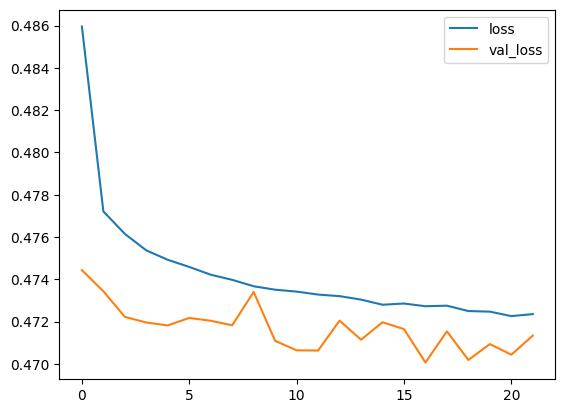

In [83]:
losses = pd.DataFrame(model.history.history)
losses.plot()

We can see from the validation loss that after around 5 epochs, the model is struggling to learn.

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score

In [84]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
#print(classification_report(y_test,predictions))

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

y_pred_proba = model.predict(X_test).flatten()
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

 108/8051 [..............................] - ETA: 11s

2025-05-30 07:05:56.851539: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


8051/8051 [==============================] - 13s 2ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.04      0.07     56215
           1       0.79      0.99      0.88    201406

    accuracy                           0.79    257621
   macro avg       0.72      0.52      0.48    257621
weighted avg       0.76      0.79      0.70    257621

Confusion Matrix:
 [[  2202  54013]
 [  1172 200234]]
8051/8051 [==============================] - 11s 1ms/step
ROC AUC Score: 0.7239904275222162


We see that the recall and f1-score are still very low for 0.

We will now assign different class weights to 0 and 1 to punish the model for not catching the 0s:

In [85]:
from sklearn.utils import class_weight

# Compute class weights automatically
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

class_weights_dict

{0: 2.297317180832802, 1: 0.6390962055368327}

In [86]:
model = Sequential()

model.add(Dense(50, activation='relu', input_shape=(50,)))
model.add(Dropout(0.2))

model.add(Dense(25,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(12,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam')

In [87]:
model.fit(x=X_train,y=y_train,epochs=25,batch_size=256,
         validation_data=(X_test,y_test),callbacks=[early_stop],class_weight=class_weights_dict)

Epoch 1/25
4026/4026 [==============================] - 21s 5ms/step - loss: 0.6317 - val_loss: 0.6113
Epoch 2/25
4026/4026 [==============================] - 22s 6ms/step - loss: 0.6241 - val_loss: 0.6159
Epoch 3/25
4026/4026 [==============================] - 22s 6ms/step - loss: 0.6226 - val_loss: 0.6045
Epoch 4/25
4026/4026 [==============================] - 20s 5ms/step - loss: 0.6216 - val_loss: 0.6043
Epoch 5/25
4026/4026 [==============================] - 22s 5ms/step - loss: 0.6212 - val_loss: 0.6087
Epoch 6/25
4026/4026 [==============================] - 22s 6ms/step - loss: 0.6210 - val_loss: 0.6214
Epoch 7/25
4026/4026 [==============================] - 20s 5ms/step - loss: 0.6205 - val_loss: 0.6176
Epoch 8/25
4026/4026 [==============================] - 22s 5ms/step - loss: 0.6201 - val_loss: 0.6029
Epoch 9/25
4026/4026 [==============================] - 22s 5ms/step - loss: 0.6199 - val_loss: 0.5824
Epoch 10/25
4026/4026 [==============================] - 20s 5ms/step - l

<Axes: >

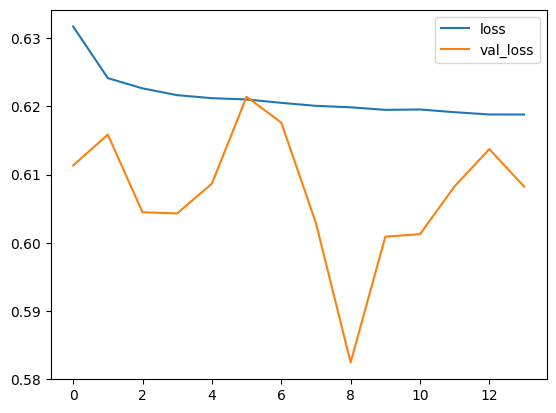

In [88]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [89]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

y_pred_proba = model.predict(X_test).flatten()
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

8051/8051 [==============================] - 11s 1ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.65      0.46     56215
           1       0.87      0.67      0.76    201406

    accuracy                           0.67    257621
   macro avg       0.61      0.66      0.61    257621
weighted avg       0.76      0.67      0.69    257621

Confusion Matrix:
 [[ 36449  19766]
 [ 65989 135417]]
8051/8051 [==============================] - 11s 1ms/step
ROC AUC Score: 0.7225523533360176


We can see that the f1-score for zeros (Charged Off) is still low.

The previous model was trained on an imbalanced dataset, with significantly more samples of Fully Paid than Charged Off. To address this, we'll now balance the dataset by sampling an equal number of instances from both classes. We'll also shuffle the dataset to ensure randomness before training.

In [25]:
# Split into two groups
charged_off = df[df['loan_repaid'] == 0]
fully_paid = df[df['loan_repaid'] == 1]

# Downsample fully_paid to match the size of charged_off
fully_paid_sampled = fully_paid.sample(n=len(charged_off), random_state=42)

# Combine both into a new balanced DataFrame
balanced_df = pd.concat([charged_off, fully_paid_sampled])

# Shuffle the balanced dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

df = balanced_df.copy()

df.shape

(560988, 51)

We'll now need to split the data as well.

In [26]:
X = df.drop('loan_repaid',axis=1).values

In [27]:
y = df['loan_repaid'].values

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
scaler = MinMaxScaler()

In [30]:
X_train = scaler.fit_transform(X_train)

In [31]:
X_test = scaler.transform(X_test)

In [32]:
X_train.shape

(448790, 50)

In [98]:
model = Sequential()

model.add(Dense(50, activation='relu', input_shape=(50,)))
model.add(Dropout(0.2))

model.add(Dense(25,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(12,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam')

In [99]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [100]:
model.fit(x=X_train,y=y_train,epochs=25,batch_size=256,
         validation_data=(X_test,y_test),callbacks=[early_stop])

Epoch 1/25
1754/1754 [==============================] - 9s 5ms/step - loss: 0.6364 - val_loss: 0.6197
Epoch 2/25
1754/1754 [==============================] - 8s 5ms/step - loss: 0.6259 - val_loss: 0.6169
Epoch 3/25
1754/1754 [==============================] - 11s 6ms/step - loss: 0.6237 - val_loss: 0.6164
Epoch 4/25
1754/1754 [==============================] - 8s 5ms/step - loss: 0.6228 - val_loss: 0.6164
Epoch 5/25
1754/1754 [==============================] - 8s 5ms/step - loss: 0.6218 - val_loss: 0.6153
Epoch 6/25
1754/1754 [==============================] - 8s 5ms/step - loss: 0.6214 - val_loss: 0.6147
Epoch 7/25
1754/1754 [==============================] - 11s 6ms/step - loss: 0.6206 - val_loss: 0.6140
Epoch 8/25
1754/1754 [==============================] - 8s 5ms/step - loss: 0.6204 - val_loss: 0.6135
Epoch 9/25
1754/1754 [==============================] - 8s 5ms/step - loss: 0.6201 - val_loss: 0.6144
Epoch 10/25
1754/1754 [==============================] - 11s 6ms/step - loss: 0.

<Axes: >

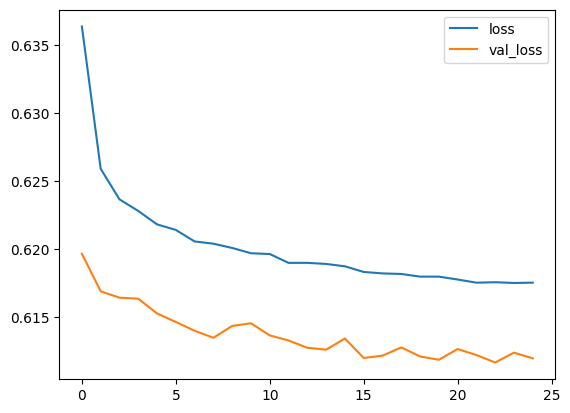

In [101]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [102]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

y_pred_proba = model.predict(X_test).flatten()
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

3507/3507 [==============================] - 7s 2ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.70      0.67     56241
           1       0.67      0.63      0.65     55957

    accuracy                           0.66    112198
   macro avg       0.66      0.66      0.66    112198
weighted avg       0.66      0.66      0.66    112198

Confusion Matrix:
 [[39249 16992]
 [20901 35056]]
3507/3507 [==============================] - 5s 1ms/step
ROC AUC Score: 0.7245988671171762


We now observe an improvement in the precision, recall, and F1-score for the negative class (0). The line chart also indicates that the model continues to learn by epoch 25 —albeit at a slow pace. It would be interesting to explore whether extending training to 50 epochs leads to further gains.

In [103]:
model = Sequential()

model.add(Dense(50, activation='relu', input_shape=(50,)))
model.add(Dropout(0.2))

model.add(Dense(25,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(12,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam')

In [104]:
model.fit(x=X_train,y=y_train,epochs=50,batch_size=256,
         validation_data=(X_test,y_test),callbacks=[early_stop])

Epoch 1/50
1754/1754 [==============================] - 11s 5ms/step - loss: 0.6359 - val_loss: 0.6193
Epoch 2/50
1754/1754 [==============================] - 8s 5ms/step - loss: 0.6260 - val_loss: 0.6177
Epoch 3/50
1754/1754 [==============================] - 8s 5ms/step - loss: 0.6240 - val_loss: 0.6165
Epoch 4/50
1754/1754 [==============================] - 11s 6ms/step - loss: 0.6228 - val_loss: 0.6170
Epoch 5/50
1754/1754 [==============================] - 8s 5ms/step - loss: 0.6221 - val_loss: 0.6164
Epoch 6/50
1754/1754 [==============================] - 8s 5ms/step - loss: 0.6218 - val_loss: 0.6146
Epoch 7/50
1754/1754 [==============================] - 8s 5ms/step - loss: 0.6208 - val_loss: 0.6152
Epoch 8/50
1754/1754 [==============================] - 11s 6ms/step - loss: 0.6202 - val_loss: 0.6141
Epoch 9/50
1754/1754 [==============================] - 8s 5ms/step - loss: 0.6202 - val_loss: 0.6147
Epoch 10/50
1754/1754 [==============================] - 8s 5ms/step - loss: 0.

In [ ]:
losses = pd.DataFrame(model.history.history)
losses.plot()

It looks like the notebook stopped printing outputs after 19 epochs, but the model should be trained and ready. Let's now evaluate again.

In [ ]:
#Save or load the model before closing the notebook

from tensorflow.keras.models import load_model
#model.save('my_model.keras')
model = load_model('my_model.keras')

In [108]:
model.save_weights("my_model_weights.h5")

In [16]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

y_pred_proba = model.predict(X_test).flatten()
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

2025-05-30 08:12:10.477560: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 12.0
2025-05-30 08:12:10.477599: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2025-05-30 08:12:10.477665: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


   1/3507 [..............................] - ETA: 5:08:14

2025-05-30 08:12:12.545204: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


3507/3507 [==============================] - 12s 2ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.72      0.68     56241
           1       0.68      0.61      0.65     55957

    accuracy                           0.66    112198
   macro avg       0.67      0.66      0.66    112198
weighted avg       0.67      0.66      0.66    112198

Confusion Matrix:
 [[40274 15967]
 [21672 34285]]
3507/3507 [==============================] - 7s 2ms/step
ROC AUC Score: 0.7255710905107232


## Interpretation of Results

- Accuracy: ~67%

  
This is within expectations for a financial classification task, especially when dealing with imbalanced data and real-world noise.

- ROC AUC: 0.725

  
A solid score. This indicates the model is reasonably effective at distinguishing between positive and negative outcomes. In practice, many financial institutions deploy models with ROC AUC scores in the 0.7–0.8 range.

- Precision/Recall Tradeoff
  
The model is capturing around 61–72% of both positive and negative cases. In loan risk assessment, this tradeoff can be adjusted based on business priorities—for example, minimizing false negatives (i.e., loans incorrectly predicted as safe) may be more critical in certain use cases.

Now that the model is trained, we’ll generate predictions on the test set. This includes:
- Predicting probabilities for each sample—representing how confident the model is that a loan will be Fully Paid or Charged Off.
- Converting those probabilities into class labels (0 or 1) using a threshold of 0.5.
- Displaying a sample comparison of the actual vs. predicted labels, along with the associated probability scores for the first 30 test samples.

This helps us manually inspect how confident and accurate the model is on real, unseen data.

In [39]:
# Predict probabilities and class labels
y_pred_proba = model.predict(X_test).flatten()
y_pred_labels = (y_pred_proba > 0.5).astype("int32")

# Create comparison df
comparison_df = pd.DataFrame({
    "Actual": y_test[:30],
    "Predicted": y_pred_labels[:30],
    "Probability of FullyPaid": y_pred_proba[:30]
})

print(comparison_df)

3507/3507 [==============================] - 5s 1ms/step
    Actual  Predicted  Probability of FullyPaid
0        1          0                  0.485877
1        1          1                  0.613678
2        0          0                  0.402501
3        1          1                  0.547328
4        0          1                  0.542941
5        0          0                  0.462537
6        1          1                  0.653828
7        1          1                  0.592482
8        0          1                  0.651821
9        0          1                  0.626538
10       1          1                  0.660522
11       0          1                  0.553396
12       1          0                  0.484983
13       0          0                  0.310565
14       0          0                  0.489772
15       0          0                  0.296063
16       0          0                  0.341523
17       0          0                  0.234426
18       0          0          

## Interpretation of Results

The DNN consistently provided highly confident and accurate predictions in low-probability ranges. For example, loans where the DNN predicted less than a 35% chance of repayment almost always defaulted in reality — demonstrating its potential as a robust early-warning tool for high-risk loans.

- Accuracy: ~67%

  
This is within expectations for a financial classification task, especially when dealing with imbalanced data and real-world noise.

- ROC AUC: 0.725

  
A solid score. This indicates the model is reasonably effective at distinguishing between positive and negative outcomes. In practice, many financial institutions deploy models with ROC AUC scores in the 0.7–0.8 range.

- Precision/Recall Tradeoff
  
The model is capturing around 61–72% of both positive and negative cases. In loan risk assessment, this tradeoff can be adjusted based on business priorities—for example, minimizing false negatives (i.e., loans incorrectly predicted as safe) may be more critical in certain use cases.